# Handling Bathymetric Data

## Background

Expeditions prior to x396T (transit from Reykjavik to Cape Town) used the SyQuest CHIRP sub-bottom profiler. A Knudsen CHIRP 3260 Echosounder was installed on x396T and has been used since. 

Processing software (needed to reprocess raw data files):
- SyQuest: Bathy2010 software
- Knudsen: SounderSuite (EchoControlServer and EchoControlClient, and PostSurvey)

The JR measures water depth using a SyQuest high-resolution CHIRP sub-bottom profiler. Ostensibly penetrating the seafloor up to 300 meters with 8 cm resolution. Bathy2010 calculates water depth using its own proprietary algorithm. Raw data are output to odc and later converted to segy file format. Comma-delimited data files are also generated realtime. A description of the segy file format is given in the Bathy2010 manual.

Navigational data was collected from Winfrog prior to expedition 395C, after expedition 395C Navipac was used instead.

- Underway laboratory notebook: https://banff.iodp.tamu.edu:8443/display/LN/Underway+Geophysics+%3A+Expeditions
- Underway User Guides: https://wiki.iodp.tamu.edu/display/LMUG/Underway+Geophysics
- Knudsen Information: https://knudseneng.com/support.php#gsc.tab=0
- SyQuest Information: https://www.syqwestinc.com/products/sub-bottom-profilers/bathy-2010
- Bathy2010 Manual: https://www.syqwestinc.com/media/bathy-2010/b2010-manual-7-14-11.pdf
- Bathy2010 Training: https://www.syqwestinc.com/media/support/bathy-2010p-trainingrp.pdf
- MGD77 format specifications: https://www.ngdc.noaa.gov/mgg/dat/geodas/docs/mgd77.pdf


## Tutorial of using segysak to manipulate segy files
- Tutorial here: https://segysak.readthedocs.io/en/latest/tutorial.html
- Datasets are converted to xarray: https://docs.xarray.dev/en/stable/examples/weather-data.html

SEGY was designed to optimize data storage on magnetic tapes

File format defined by SEG Organization:

```
Consists of optional 128 byte SEG-Y Tape Label
3200 byte Textual File Header
400 byte Binary File Header
1 Optional 3200 byte Extended Textual File Header
...
N 3200 byte Extended Textual File Header 
1 or more 240 Trace 1 Headers
1st Data Trace
...
1 or more 240 Trace M Headers
...
Mth Data Trace
Optional Data Trailer, 1 or more 3200 byte records
```

A "trace" is analogous to a single continuous data reading of a seismic response (a single waveform) by the receiver present after the emitter "pings". The SyQuest Bathy2010 for example measures traces that are 5000 data points long, where each point in the trace is identified by the two-way traveltime (TWT) and a transducer power signal. The TWT are measured at the same time points across all traces in the survey.


## Import libraries and data

In [1]:
import pandas as pd
import pathlib
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pathlib
from IPython.display import display
import xarray as xr
from datetime import datetime

# segysak libraries:
from segysak.segy import segy_header_scan
from segysak.segy import segy_header_scrape
from segysak.segy import segy_loader, well_known_byte_locs
from segysak.segy import get_segy_texthead
import segyio


C:\Users\vpercuoco\AppData\Roaming\Python\Python39\site-packages\segysak\segy\_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Helper function for inserting columns at certain indices in dataframe

def insert_column(df, position,name,value):
    if name not in df:
        df.insert(position,name,value)

# Data Reduction: Converting Bathymetric SEG-Y data to MGD77T format

In [3]:
extra_fields = None
if extra_fields is None:
    extra_fields = {}

### Information about MGD77T data columns

In [4]:
# specified field values. The MGD77T documentation defines each of these fields, their data types, and provides some examples.

# survey identifier
# survey_id = "JR378"

# time-zone correction. Adds to local timezone to convert time into GMT.
# We always use CMT which is a 6 hour difference.
# timezone = 6

# date
# date: specified in the csv's corresponding odc/segy file name.

# time:
# time: specified in the data. Must be in hours and decimal minutes

# latitude
# lat: specified in the data. Must be in decimal format

# longitude
# lon: specified in the data. Must be in decimal degrees

# Position type code
# 1 for "observed fix"
# pos_type = 1

# Quality code for navigation
# 1 for "good"
# nav_qualco = 1

################## Bathymetric Parameters ######################

# bathymetry, 2 way traveltime in seconds
# this type of correction can only be applied by someone who understands how to manipulate data in the segy files.
# bat_ttime = None

# corrected depth. Positive meters
# corr_depth: specified in data

# bathymetric correction code
# we use a Matthews Correction and the correction code may be given in a "depth_corrections" excel file in data1 alongside the bathymetry csv files
# if the correction code cannot be found then specify "98" here
# bat_cpco = 98

# bathymetric type code
# bat_typco = 1 

# quality code for bathymetry
# bat_qualco = 1

################## Magnetic Parameters ######################

# Magnetics total field, 1st sensor (leading sensor)
# should be in nanoTesla, nT
# mag_tot: specified in the data

# Magnetics total field, 2st sensor (trailing sensor)
# should be in nanoTesla, nT
# mag_tot2: our maggie doesn't have a secondary sensor

# magnetics residual field
#mag_res 

# sensor for residual field
#mag_ressen

# magnetics diurnal correction
#mag_dicorr

# depth/altitude of magnetics sensor. Meters below sealevel
# mag_sdepth: specified in the data

# Quality code for magnetics
# mag_qualco = 1


################## Gravity Parameters ######################
# our instrumentation does not capture gravimetric information. These fields are excluded from the reports.

# gra_obs
# eotvos
# freeair
# gra_qualco
# lineid
# pointid



# Convert Bathymetric Data from SEGY to MGD77

I initially did all this using the csv files output by the Bathy2010 software but found out later that it is much easier to work directly with the seg-y files.

For csv files:

The csv files are exported from the SyQuest Bathy 2010 software by the underway technician. The files should contain at the minimum: latitude, longitude, and water depth (m). The start datetime of the survey is usually giving in the csv file header. Manually read the date for from the file header and insert in the graph below.

Raw data csvs must be processed individually using the scripts below.

Process files based on their surveys/expeditions. For example, do not try to process x355, x356 in the same go. Process all the x355 files, then do the same steps for x356 files.

In [5]:
# Data structure to contain all the user input data for individual bathymetric files
# Complete this data graph prior to running the rest of the notebook. The functionality below needs this info to work properly.
# Leave the "extra" fields as "None". Values will be populated for those fields when processing individual files

bathy_graph = {
    1 : 
        {
        "filename":"20200105234732-1.CSV",  # filename of the bathymetric survey
        "filepath":"./input_files/bathymetric/20200105234732-1.CSV", # path of file
        "segy_file":"./input_files/bathymetric/20200105234732R-LF.seg",
        "export_filename":'./export_files/bathymetric/jr378_1.m77t', # path were cleaned file will be exported
        "survey_id": "jr378", # name of the survey. This should be the same as the survey name in the survey header file
        "timezone": 6, # time zone difference. A positive number added to the local time in the file to convert it to GMT. See the MGD77T documentation for more info
        "first_date" : {    # the date the survey began. Get this for the file name. This value is necessary to build off of to include dates in the cleaned file
            "day": 5,
            "month": 1,
            "year": 2020
        },
        "pos_type": 1,  # position type code. Typically set to "1". See MGD77T documentation
        "nav_qualco": 1, # quality code for navigation.  Typically set to "1". See MGD77T documentation 
        "bat_ttime":None, # bathymetry 2 way traveltime. This data is not included in the csv. Possibly it is included in the segy files but more experience is needed to parse it.
        "bat_cpco": 98, # bathymetric correction code. See MGD77T documentation 
        "bat_typco": 1, # bathymetric type code. Typically set to "1". See MGD77T documentation 
        "bat_qualco": 1, # quality code for bathymetry. ypically set to "1". See MGD77T documentation 
        "extra" : # leave the extra fields here blank. The code below will populate these values with specific LAT/LON min/max values from individual files. They are used later when finalizing the bathymetric header file.
            {
                "LAT_TOP": None,
                "LAT_BOTTOM": None,
                "LON_LEFT": None,
                "LON_RIGHT":None,
                "IDS_10DEG":[]
            }
    },
    2 : # Keep copying the data graph to include as many records as bathymetric files for this survey. Make sure to update parameters as need be.
        {
        "filename":"20200129003852-1.CSV",
        "filepath":"./input_files/bathymetric/20200129003852-1.CSV",
        "segy_file":"./input_files/bathymetric/20200129003852-1-LF.seg",
        "export_filename":'./export_files/bathymetric/jr378_2.m77t',
        "survey_id": "jr378",
        "timezone": 6,
        "first_date" : {
            "day": 29,
            "month": 1,
            "year": 2020
        },
        "pos_type": 1,
        "nav_qualco": 1,
        "bat_ttime":None,
        "bat_cpco": 98,
        "bat_typco": 1,
        "bat_qualco": 1,
        "extra" : 
            {
            "LAT_TOP": None,
            "LAT_BOTTOM": None,
            "LON_LEFT": None,
            "LON_RIGHT":None,
            "IDS_10DEG":[]
            }
        } 
}

In [6]:
# Creates an iterable
iterable = iter(bathy_graph.values())

### Run from this cell down for each file iteration

In [17]:
# Run this cell on down for as many files as there are
record = next(iterable)
record


{'filename': '20200129003852-1.CSV',
 'filepath': './input_files/bathymetric/20200129003852-1.CSV',
 'segy_file': './input_files/bathymetric/20200129003852-1-LF.seg',
 'export_filename': './export_files/bathymetric/jr378_2.m77t',
 'survey_id': 'jr378',
 'timezone': 6,
 'first_date': {'day': 29, 'month': 1, 'year': 2020},
 'pos_type': 1,
 'nav_qualco': 1,
 'bat_ttime': None,
 'bat_cpco': 98,
 'bat_typco': 1,
 'bat_qualco': 1,
 'extra': {'LAT_TOP': None,
  'LAT_BOTTOM': None,
  'LON_LEFT': None,
  'LON_RIGHT': None,
  'IDS_10DEG': []}}

### Import SEG-Y file

In [18]:
# import file
segy = pathlib.Path(record['segy_file'])
print("Does file exist: ", segy, segy.exists())

trace_headers = segy_header_scrape(segy)
trace_headers.head()

Does file exist:  input_files\bathymetric\20200129003852-1-LF.seg True


  0%|          | 0.00/35.4k [00:00<?, ? traces/s]

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,0,10001,1,1,0,10001,0,0,0,0,...,64,-25531,0,0,0,0,0,0,0,0
1,0,10001,2,1,0,10001,0,0,0,0,...,64,-25531,0,0,0,0,0,0,0,0
2,0,10001,3,1,0,10001,0,0,0,0,...,64,-25531,0,0,0,0,0,0,0,0
3,0,10001,4,1,0,10001,0,0,0,0,...,64,-25531,0,0,0,0,0,0,0,0
4,0,10001,5,1,0,10001,0,0,0,0,...,64,-25531,0,0,0,0,0,0,0,0


### Convert data

In [19]:
# Columns with actual data
# FieldRecord is the trace number (POINTID)
# SourceWaterDepth and GroupWaterDepth are the same. They are the final water depths. Need to divide by 10.
# SourceX and SourceY are the longitude and latitude coordinates as 32 bit floating points. In arcseconds, need an additional divisor of 1000

mgd = trace_headers[['FieldRecord','SourceWaterDepth','SourceY','SourceX','YearDataRecorded','DayOfYear','HourOfDay','MinuteOfHour','SecondOfMinute']].copy()

mgd.rename(columns={
    'FieldRecord':'POINTID',
    'SourceWaterDepth':'CORR_DEPTH',
    'SourceY': 'LAT',
    'SourceX': 'LON'}, inplace=True)

#### Convert time ####
# cconversion is to {hours}{decimal minutes}, rounded to 4 decimal places per MGD77T specs
# difficult thing is to ensure 0's are padding the beginning and trailing of the HHMM.MMMM 
# for example, 01:00:40 = 0100.6667; 07:34:45 = 0734.7500
''' A different way of doing this. Incomplete but useful for future reference:
mgd['TIME'] = mgd['HourOfDay'].astype('str') + ":" + mgd['MinuteOfHour'].astype('str')
mgd['TIME'] = pd.to_datetime(mgd['TIME'], format='%H:%M')
f = lambda x: datetime.strftime(x, "%H%M")
mgd['TIME'] = mgd['TIME'].map(f)
'''

mgd['HOUR'] = mgd['HourOfDay'].astype('str').apply(lambda x: x.zfill(2))
# ensures the minutes are decimal minutes, with 4 decimal places and padded with beginning 0's to have the form 00.0000
mgd['MINUTE'] = (mgd['MinuteOfHour']+ mgd['SecondOfMinute']/60).round(4).apply(lambda x: ("{:.4f}".format(x).zfill(7)))
mgd['TIME'] = mgd['HOUR'] + mgd['MINUTE']

#### Convert date ####
# Difficult part is that the month is not included an instead "DayOfYear" is used. Jeez.
# see datetime directives here: https://www.w3schools.com/python/python_datetime.asp
mgd['DATE'] = mgd['YearDataRecorded'].astype('str') + "-" + mgd['DayOfYear'].astype('str')
f = lambda x: datetime.strptime(x,"%Y-%j").strftime("%Y%m%d")
mgd['DATE'] = mgd['DATE'].map(f)


#### Drop columns ####
mgd.drop(columns=['YearDataRecorded','HourOfDay','MinuteOfHour','DayOfYear','SecondOfMinute', 'HOUR','MINUTE'], inplace=True)

#### Convert Depth ####
# seems that depth is in meters*10. 
mgd['CORR_DEPTH'] = mgd['CORR_DEPTH']/10

#### Convert latitude and longitude ####
# According to the Bathy2010 manual LAT/LON are stored as 32-bit floating point numbers (but seem to be integers...).
# The software defaults to exporting units of arcseconds. Divide by 3600 to convert to degrees
# The additional 1000 divisor is due to the amount of precision in the float, but when stored as int the decimal point is excluded.
# I compared the values calcuated here with the LAT/LON values present in the csv directly exported by Bathy2010 and there is a 1-to-1 correspondence
mgd['LAT'] = (mgd['LAT']/3600/1000).round(6)
mgd['LON'] = (mgd['LON']/3600/1000).round(6)


#### Reorder Columns ####
mgd = mgd[['DATE','TIME','LAT','LON','CORR_DEPTH','POINTID']]
mgd.head()


,DATE,TIME,LAT,LON,CORR_DEPTH,POINTID
0,19700101,0000.0000,0.000000,0.000000,0.0,1
1,20200129,0038.9500,-42.390892,177.047553,2669.0,2
2,20200129,0039.1167,-42.390525,177.048098,2669.0,3
3,20200129,0039.2833,-42.390148,177.048657,2669.0,4
4,20200129,0039.4500,-42.389780,177.049207,2670.9,5


### Insert extra columns

The column order must follow that specified in MGD77T

In [20]:
insert_column(mgd, 0, 'SURVEY_ID',record['survey_id'])
insert_column(mgd, 1,'TIMEZONE',record['timezone'])
# 2: DATE
# 3: TIME
# 4: LAT
# 5: LON
insert_column(mgd, 6,'POS_TYPE',record['pos_type'])
insert_column(mgd, 7,'NAV_QUALCO',record['nav_qualco'])
insert_column(mgd, 8,'BAT_TTIME',record['bat_ttime'])
# 9: CORR_DEPTH
insert_column(mgd, 10,'BAT_CPCO',record['bat_cpco'])
insert_column(mgd, 11,'BAT_TYPCO',record['bat_typco'])
insert_column(mgd, 12,'BAT_QUALCO',record['bat_qualco'])
insert_column(mgd,13,"MAG_TOT",None)
insert_column(mgd,14,"MAG_TOT2",None)
insert_column(mgd,15,"MAG_RES",None)
insert_column(mgd,16,"MAG_RESSEN",None)
insert_column(mgd,17,"MAG_DICORR",None)
insert_column(mgd,18,"MAG_SDEPTH",None)
insert_column(mgd,19,"MAG_QUALCO",None)
insert_column(mgd,20,"GRA_OBS",None)
insert_column(mgd,21,"EOTVOS",None)
insert_column(mgd,22,"FREEAIR",None)
insert_column(mgd,23,"GRA_QUALCO",None)
insert_column(mgd,24,"LINEID",None)
# 25: POINTID

mgd.head()

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,jr378,6,19700101,0000.0000,0.000000,0.000000,1,1,None,0.0,...,None,None,None,None,None,None,None,None,None,1
1,jr378,6,20200129,0038.9500,-42.390892,177.047553,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,2
2,jr378,6,20200129,0039.1167,-42.390525,177.048098,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,3
3,jr378,6,20200129,0039.2833,-42.390148,177.048657,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,4
4,jr378,6,20200129,0039.4500,-42.389780,177.049207,1,1,None,2670.9,...,None,None,None,None,None,None,None,None,None,5


### Do any final/custom dataframe editing here before export

Certain rows my need to be filtered out:
- where the date is invalid
- where the lat/lon are 0 and 0
- where the water depth is 0

In [21]:
if record['filename'] == '20200129003852-1.CSV':
    mgd = mgd.iloc[1:,:]
    mgd.reset_index(inplace=True,drop=True)
mgd

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,jr378,6,20200129,0038.9500,-42.390892,177.047553,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,2
1,jr378,6,20200129,0039.1167,-42.390525,177.048098,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,3
2,jr378,6,20200129,0039.2833,-42.390148,177.048657,1,1,None,2669.0,...,None,None,None,None,None,None,None,None,None,4
3,jr378,6,20200129,0039.4500,-42.389780,177.049207,1,1,None,2670.9,...,None,None,None,None,None,None,None,None,None,5
4,jr378,6,20200129,0039.6167,-42.389408,177.049773,1,1,None,2670.9,...,None,None,None,None,None,None,None,None,None,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35346,jr378,6,20200204,1713.4333,-22.736920,-155.961982,1,1,None,5693.8,...,None,None,None,None,None,None,None,None,None,35348
35347,jr378,6,20200204,1713.7667,-22.736228,-155.961147,1,1,None,5693.8,...,None,None,None,None,None,None,None,None,None,35349
35348,jr378,6,20200204,1714.1000,-22.735532,-155.960320,1,1,None,5013.4,...,None,None,None,None,None,None,None,None,None,35350
35349,jr378,6,20200204,1714.4333,-22.734833,-155.959500,1,1,None,5013.6,...,None,None,None,None,None,None,None,None,None,35351


### Save summary data and export data report

The exported data must be tab delimited. The summary data are metadata from the individual file that will need to be included in the MGD77T header file.

In [22]:
mgd.to_csv(record['export_filename'], sep='\t', index=False)

In [23]:
# errors where the latitude and longitude values were not fed to Bathy2010. Both LAT and LON are 0.
mgd[(mgd['LAT']==0) & (mgd['LON']==0)]

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
22762,jr378,6,20200201,1918.5333,0.0,0.0,1,1,None,5334.1,...,None,None,None,None,None,None,None,None,None,22764
22763,jr378,6,20200201,1918.8667,0.0,0.0,1,1,None,5331.8,...,None,None,None,None,None,None,None,None,None,22765


### Get 10 Degree Squares

In [172]:
def get_10degree_squares(latitude: pd.Series,longitude: pd.Series):
    """Determines the unique 10 degree square codes for given latitudes and longitudes. The two series must have equal length. See MGD77T Appendix A documentation.

    Args:
        latitude (pd.Series): A pandas Series of latitude values in decimal degrees format.
        longitude (pd.Series): A pandas Series of longitude values in decimal degrees format.

    Returns:
        np.ndarray : An array of unique 4 character 10 degree square codes.
    """
    
    if len(latitude) != len(longitude):
        raise Exception('Series not equal') 
    
    
    i=0
    quad = []
    for i in range(0,len(latitude)):
        lat = latitude.iloc[i]
        lon = longitude.iloc[i]
        
        
        if lat >= 0 and lon >= 0:
            quad.append(1)
        elif lat >= 0 and lon < 0:
            quad.append(7)
        elif lat < 0 and lon >= 0:
            quad.append(3)
        else: quad.append(5)
        i+=1
    
    # FYI for longtiude: Take absolute value of decimal longitude, make sure zfill (pad) front with zeros, then take the first 2 characters.    
    return (np.array(quad).astype('str') + latitude.map(lambda x: str(int(abs(x))).zfill(2)[0]) + longitude.map(lambda x: str(int(abs(x))).zfill(3)[:2])).unique()


### Get bathymetric sampling rate

In [25]:

#### Determining general bathymetric sampling rate ####
a = mgd['TIME'].astype('float').diff()

# because the time is {hours}{decimal minutes} all negative values of diff indicate the elapse of a day. Removing those with a>0
# a<10 will ignore time gaps longer than 10 minutes, assuming at that point the readings have ceased.
np.average(a[(a>0)& (a<10)])

0.27171623280663865

In [26]:
# create dictionary if it doesn't exist. Storing new data to the same key will just overwrite the previous data.

# If lat/long values were misread by Bathy2010 the software outputs 0 for both. Filtering out those when checking LEFT/RIGHT,TOP/BOTTOM values
lat = mgd[(mgd['LAT']!=0) & (mgd['LON']!=0)].loc[:,'LAT']
lon = mgd[(mgd['LAT']!=0) & (mgd['LON']!=0)].loc[:,'LON']

record['extra']['IDS_10DEG'] = get_10degree_squares(lat,lon)


record['extra']["LAT_TOP"] = lat.max()
record['extra']['LAT_BOTTOM'] = lat.min()
record['extra']['LON_LEFT'] = lon.min()
record['extra']['LON_RIGHT'] = lon.max()



[bathy_graph[x]['extra'] for x in bathy_graph]

[{'LAT_TOP': -18.385608,
  'LAT_BOTTOM': -52.223558,
  'LON_LEFT': 166.191703,
  'LON_RIGHT': 179.102543,
  'IDS_10DEG': array(['3117', '3217', '3317', '3417', '3416', '3516'], dtype=object)},
 {'LAT_TOP': -22.734143,
  'LAT_BOTTOM': -42.390892,
  'LON_LEFT': -179.999712,
  'LON_RIGHT': 179.999708,
  'IDS_10DEG': array(['3417', '5417', '5317', '5316', '5216', '5215'], dtype=object)}]

## Manually loop back up at this point to run the next file iteration

Only move on if all bathymetric files have been processed.

## Create the MGD77 header record

The purpose of the (survey) Header Record is to document the content of the geophysical data contained within the data records. In general, documentation that is constant throughout the survey will be in the Header Record, while data that is variable will be in the Data Records.

The Header Record contains fields which are numeric and freely formatted text. Each field is followed by a tab character. Unspecified or unused fields are nil (a tab immediately follows the previous field). Tabs are generally omitted for any trailing unspecified fields, including the tab for the last specified field.

MGD77T headers for groups of surveys can be contained in a single file or in separate files (one file per survey). Generally the grouping method will be the same as that of the MGD77T data files.

The MGD77T survey header(s) file may optionally have a heading record of field identifiers as the first record of the file, followed by the actual survey header(s). The field identifier names offered in this format description below are not to be considered as the “official” field identifier names. Users may offer their own field id names, or not insert a heading record in the survey header(s) file. However, the use of name “FORMAT_77” as the second field identifier of the first record of the file will make it easy for applications to determine that this record is a heading record for a MGD77T survey header(s) file in same way that “MGD77T” in the second field of a record identifies the record as a MGD77T survey header record.


Only one header record file is created. The metadata in this file pertains to all the data files in the dataset.

In [27]:

headers = {
    
# The identifier for the data specified by us
# Format for bathymetric data: JR378
# format for magnetic data: JR378M
'SURVEY_ID': 'jr378',

# The header/data format
'FORMAT_77' : 'MGD77T',

# The data center file number. Get this from previous submissions of NCEI data.
'CENTER_ID' : '23060167' ,

# Geophysical parameters measured in this survey. We submit bathymetric/magnetic data as two different datasets. 
# See MGD77T documentation
'PARAMS_CO' : '55111',

# this is today's date. Or whenever this data was compiled here.
'DATE_CREAT' : '20221122',

# Source Institution:
# who collected the data
'INST_SRC' :  'International Ocean Discovery Program',

# Country of source institution
'COUNTRY' : 'USA',

# Platform name
'PLATFORM' : 'JOIDES Resolution',

# Platform type code
# 1 for "surface ship"
'PLAT_TYPCO' : '1',

# Platform type
'PLAT_TYPE' :'Ship',

# Both chief scientists
'CHIEF' : 'Thomas, D.J., Röhl, U.',

# Project, cruise or leg
'PROJECT' : "Expedition 378",

# Agency or instituion providing the funding
'FUNDING' : "NSF and other IODP Members",

# Survey departure date - YYYYMMDD
# This is found in the proceedings volume. The date the ship left port (not the beginning of port call).
'DATE_DEP' : '20200105',

# Port of departure
'PORT_DEP' : 'Lautoka, Fiji',

# Survey arrival date - YYYYMMDD
'DATE_ARR' : '20200206',

# Port of arrival
'PORT_ARR' : 'Papeete, Tahiti',

# Navigational instrumentation
'NAV_INSTR' : 'GPS',

# Position determination method
'POS_INFO' : 'WGS84/Primary-Satellite',

# Bathymetric Instrumentation
'BATH_INTR' : 'SyQuest Bathy 2010 CHIRP',

# Additional forms of bathymetry
'BATH_ADD' : '3.5 kHz',

# Magnetics instrumentation
'MAG_INSTR' : 'SeaSpy magnetometer',

# Additional forms of magnetics
# Not used
'MAD_ADD': None,

# Gravity instrumentation
# Not used
'GRAV_INSTR' : None,

# Additional forms of gravity data
# Not used
'GRAV_ADD' : None,

# Seismic instrumentation
# Not used
'SEIS_INSTR' : None,

# Formats of seismic data
# Not used
'SEIS_FRMTS' : None,

# Northbound latitude of survey
# Determined automatically further down below...
'LAT_TOP' : None,

# Southbound latitude of survey
# Determined automatically further down below...
'LAT_BOTTOM': None,

# Westbound longitude of survey
# Determined automatically further down below...
'LON_LEFT': None,

# Eastbound longitude of survey
# Determined automatically further down below...
'LON_RIGHT': None,

# General digitizing rate of bathymetry
'BATH_DRATE': None,

# General sampling rate of bathymetry
'BATH_SRATE': None,

# Assumed sound velocity
'SOUND_VEL': '1500',

# Bathymetric vertical datum code. See MGD77T for codes
# Using 00 "No correction applied"
'VDATUM_CO': '00',

# Interpolation Scheme
# No info about bathymetric interpolation scheme
'BATH_INTRP': None,

# General digitizing rate of magnetics
# Inspect the raw XYZ files to get the time difference between measurements
'MAG_DRATE': '0.05',

# General sampling rate of magnetics
# Maggie cycles at 0.3 Hz according to User Guide
'MAG_SRATE': '0.3',

# Magnetic sensor tow distance
# According to the Underway Maggie User Guide we use a tow distance of ~435 meters
'MAG_TOWDST' : '435',

# Sensor depth
# Determined automatically further down below...
'MAG_SNSDEP' : None,

# Horizontal sensor separation
# this is only used for maggies with 2 sensors. We don't use, set to None
'MAG_SNSSEP' : None,

# Reference field code. See MGD77T documentaion for codes
# We do not apply a residual magnetics correction (pers comm Gary Acton). Set too "00" for "Unused"
'M_REFFL_CO' : '00',

# Reference field
# No reference field correction applied, set to none
'MAG_REFFLD' : None,

# Method of applying residual field
# No reference field correction applied, set to none
'MAG_RF_MTH' : None,

# General digitizing rate of gravity
# Not used
'GRAV_DRATE' : None,

# General sampling rate of gravity
# Not used
'GRAV_SRATE' : None,

# Theoretical gravity formula code
# Not used
'G_FORMU_CO' : None,

# Theoretical gravity formula
# Not used
'GRAV_FORMU' : None,

# Reference system code
# Not used
'G_RFSYS_CO' : None,

# Reference system
# Not used
'GRAV_RFSYS' : None,

# Corrections applied
# Not used
'GRAV_CORR' : None,

# Departure base station gravity
# Not used
'G_ST_DEP_G' : None,

# Departure base station description
# Not used
'G_ST_DEP' : None,

# Arrival base station gravity
# Not used
'G_ST_ARR_G' : None,

# Arrival base station description
# Not used
'G_ST_ARR' : None,

# Number of 10-degree identifiers
# Determined automatically further down below...
'IDS_10_NUM' : None,

# 10-degree identifiers
# Determined automatically further down below...
'IDS_10DEG' : None,

# Additional documentation
# Not used
'ADD_DOC' : None

}

headers

{'SURVEY_ID': 'jr378',
 'FORMAT_77': 'MGD77T',
 'CENTER_ID': '23060167',
 'PARAMS_CO': '55111',
 'DATE_CREAT': '20221122',
 'INST_SRC': 'International Ocean Discovery Program',
 'COUNTRY': 'USA',
 'PLATFORM': 'JOIDES Resolution',
 'PLAT_TYPCO': '1',
 'PLAT_TYPE': 'Ship',
 'CHIEF': 'Thomas, D.J., Röhl, U.',
 'PROJECT': 'Expedition 378',
 'FUNDING': 'NSF and other IODP Members',
 'DATE_DEP': '20200105',
 'PORT_DEP': 'Lautoka, Fiji',
 'DATE_ARR': '20200206',
 'PORT_ARR': 'Papeete, Tahiti',
 'NAV_INSTR': 'GPS',
 'POS_INFO': 'WGS84/Primary-Satellite',
 'BATH_INTR': 'SyQuest Bathy 2010 CHIRP',
 'BATH_ADD': '3.5 kHz',
 'MAG_INSTR': 'SeaSpy magnetometer',
 'MAD_ADD': None,
 'GRAV_INSTR': None,
 'GRAV_ADD': None,
 'SEIS_INSTR': None,
 'SEIS_FRMTS': None,
 'LAT_TOP': None,
 'LAT_BOTTOM': None,
 'LON_LEFT': None,
 'LON_RIGHT': None,
 'BATH_DRATE': None,
 'BATH_SRATE': None,
 'SOUND_VEL': '1500',
 'VDATUM_CO': '00',
 'BATH_INTRP': None,
 'MAG_DRATE': '0.05',
 'MAG_SRATE': '0.3',
 'MAG_TOWDST': '43

In [28]:
### The header file will be exported for bathymetric and magnetics datasets. It must set nonrelevant fields = None.
# for example, in the bathymetric header file all the magnetic_headers and other_headers I specified above must be None
bathymetric_headers=[
'BATH_INTR',
'BATH_ADD',
'BATH_DRATE',
'BATH_SRATE',
'SOUND_VEL',
'VDATUM_CO',
'BATH_INTRP']

magnetic_headers=[
'MAG_INSTR',
'MAD_ADD',
'MAG_DRATE',
'MAG_SRATE',
'MAG_TOWDST',
'MAG_SNSDEP',
'MAG_SNSSEP',
'M_REFFL_CO',
'MAG_REFFLD',
'MAG_RF_MTH']

other_headers=[
'GRAV_INSTR',
'GRAV_ADD',
'SEIS_INSTR',
'SEIS_FRMTS',
'GRAV_DRATE',
'GRAV_SRATE',
'G_FORMU_CO',
'GRAV_FORMU',
'G_RFSYS_CO',
'GRAV_RFSYS',
'GRAV_CORR',
'G_ST_DEP_G',
'G_ST_DEP',
'G_ST_ARR_G',
'G_ST_ARR']




## Additional fields parsed from the data which should be used to complete the MDG77T header file

This keeps a running dictionary of field value from all exported csvs. Using the csv names as keys in the dictionary. Use this data structure to pull out summary values that need to be included in the MDG77T file header. For example, the survey northboud latitude is the highest (positive) latitude the ship traveled during the expedition. Here we are storing the highest latitude from each file, which we can then use to find the northernmost among all files.

In [29]:
[bathy_graph[x]['extra'] for x in bathy_graph]

[{'LAT_TOP': -18.385608,
  'LAT_BOTTOM': -52.223558,
  'LON_LEFT': 166.191703,
  'LON_RIGHT': 179.102543,
  'IDS_10DEG': array(['3117', '3217', '3317', '3417', '3416', '3516'], dtype=object)},
 {'LAT_TOP': -22.734143,
  'LAT_BOTTOM': -42.390892,
  'LON_LEFT': -179.999712,
  'LON_RIGHT': 179.999708,
  'IDS_10DEG': array(['3417', '5417', '5317', '5316', '5216', '5215'], dtype=object)}]

In [30]:
headers['LAT_TOP'] = np.max([bathy_graph[x]['extra']['LAT_TOP'] for x in bathy_graph])
headers['LON_RIGHT'] = np.max([bathy_graph[x]['extra']['LON_RIGHT'] for x in bathy_graph])
headers['LAT_BOTTOM'] = np.min([bathy_graph[x]['extra']['LAT_BOTTOM'] for x in bathy_graph])
headers['LON_LEFT'] = np.min([bathy_graph[x]['extra']['LON_LEFT'] for x in bathy_graph])

IDS_10DEG = np.unique(np.concatenate([bathy_graph[x]['extra']['IDS_10DEG'] for x in bathy_graph],axis=0))

# The number of unique IDS_10DEG numbers
headers['IDS_10_NUM'] = len(IDS_10DEG)

# MGD77T specifies to concatenate all the 4-digit values together then append "9999"
headers['IDS_10DEG'] = "".join(IDS_10DEG) + "9999"

## Save header file

In [31]:
df_headers = pd.DataFrame.from_dict([headers],orient='columns')
df_headers.head()


,SURVEY_ID,FORMAT_77,CENTER_ID,PARAMS_CO,DATE_CREAT,INST_SRC,COUNTRY,PLATFORM,PLAT_TYPCO,PLAT_TYPE,...,G_RFSYS_CO,GRAV_RFSYS,GRAV_CORR,G_ST_DEP_G,G_ST_DEP,G_ST_ARR_G,G_ST_ARR,IDS_10_NUM,IDS_10DEG,ADD_DOC
0,jr378,MGD77T,23060167,55111,20221122,International Ocean Discovery Program,USA,JOIDES Resolution,1,Ship,...,None,None,None,None,None,None,None,11,311732173317341634173516521552165316531754179999,None


In [32]:
# Export bathymetric headers file
df_headers = pd.DataFrame.from_dict([headers],orient='columns')
df_headers[magnetic_headers] = None # don't want magnetometer parameters in the bathymetric header file
df_headers.to_csv(f"./export_files/bathymetric/{record['survey_id']}.h77t", sep='\t', index=False)



# Data Reduction: Converting underway magnetometer data

Check to make sure that the header of the log file is not repeated throughout the file. If the data logging stops/starts it will reprint the header in the middle of the data.

In [194]:
# Data structure to contain all the user input data for individual magnetic files
# Complete this data graph prior to running the rest of the notebook. The functionality below needs this info to work properly.
# Leave the "extra" fields as "None". Values will be populated for those fields when processing individual files

maggie_graph = {
    1 : 
        {
        "filename":"X378_L1T.XYZ",  # filename of the magnetic survey
        "filepath":"./input_files/magnetic/X378_L1T.XYZ", # path of file
        "export_filename":'./export_files/magnetic/jr378m_1.m77t', # path where cleaned file will be exported
        "survey_id": "jr378m", # name of the survey. This should be the same as the survey name in the survey header file
        "timezone": 6, # time zone difference. A positive number added to the local time in the file to convert it to GMT. See the MGD77T documentation for more info
        "pos_type": 1,  # position type code. Typically set to "1". See MGD77T documentation
        "nav_qualco": 1, # quality code for navigation.  Typically set to "1". See MGD77T documentation 
        "mag_tot2" : None, # magnetics total field for a secondary sensor. Ours is single sensors so leave as "None".
        "mag_res": None, # magnetics residual field. See MGD77T documentation.
        "mag_ressen": None, # sensor for residual field. Leave as none in indicate a single sensor. See MGD77T documentation.
        "mag_dicorr": None, # magnetics diurnal correction. Leave as None unless you know how a diurnal correction was applied. what See MGD77T documentation.
        "mag_qualco": 1, # quality code for magnetics. Typically set to "1". See MGD77T documentation 
        "extra" : # leave the extra fields here blank. The code below will populate these values with specific LAT/LON min/max values from individual files. They are used later when finalizing the bathymetric header file.
            {
                'MAG_SNSDEP' : None,
                "LAT_TOP": None,
                "LAT_BOTTOM": None,
                "LON_LEFT": None,
                "LON_RIGHT":None,
                "IDS_10DEG":[]
            }
    },
    2 : # Keep copying the data graph to include as many records as magnetic files for this survey. Make sure to update parameters as need be.
        {
        "filename":"X378_L2T.XYZ",  
        "filepath":"./input_files/magnetic/X378_L2T.XYZ", 
        "export_filename":'./export_files/magnetic/jr387m_2.m77t', 
        "survey_id": "jr378m",
        "timezone": 6, 
        "pos_type": 1,  
        "nav_qualco": 1,
        "mag_tot2" : None,
        "mag_res": None,
        "mag_ressen": None,
        "mag_dicorr": None,
        "mag_qualco": 1, 
        "extra" : 
            {
                'MAG_SNSDEP' : None,
                "LAT_TOP": None,
                "LAT_BOTTOM": None,
                "LON_LEFT": None,
                "LON_RIGHT":None,
                "IDS_10DEG":[]
            }
    },
}

In [195]:
# Creates an interable
iterable = iter(maggie_graph.values())

In [207]:
record = next(iterable)
record

{'filename': 'X378_L2T.XYZ',
 'filepath': './input_files/magnetic/X378_L2T.XYZ',
 'export_filename': './export_files/magnetic/jr387m_2.m77t',
 'survey_id': 'jr378m',
 'timezone': 6,
 'pos_type': 1,
 'nav_qualco': 1,
 'mag_tot2': None,
 'mag_res': None,
 'mag_ressen': None,
 'mag_dicorr': None,
 'mag_qualco': 1,
 'extra': {'MAG_SNSDEP': None,
  'LAT_TOP': None,
  'LAT_BOTTOM': None,
  'LON_LEFT': None,
  'LON_RIGHT': None,
  'IDS_10DEG': []}}

In [208]:
csv = pathlib.Path(record['filepath'])
print("Does file exist: ", csv, csv.exists())

# I had to manually inspect the XYZ files to see how many rows to skip
num_header_rows = 5

mag = pd.read_csv(record['filepath'], skiprows=num_header_rows)

mag.head()

Does file exist:  input_files\magnetic\X378_L2T.XYZ True


C:\Users\vpercuoco\AppData\Local\Temp\ipykernel_17940\4198023574.py:7: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mag = pd.read_csv(record['filepath'], skiprows=num_header_rows)


,/Date,Time,Field_Mag1,Depth_Mag1,Longitude,Latitude
0,2020/01/30,06:18:15.2,52891.789,0.7m,-177.169934,-38.549290
1,2020/01/30,06:18:18.5,52893.152,0.7m,-177.169762,-38.549175
2,2020/01/30,06:18:21.5,52892.598,0.6m,-177.169606,-38.549073
3,2020/01/30,06:18:24.5,52892.574,0.6m,-177.169452,-38.548967
4,2020/01/30,06:18:27.5,52894.301,0.7m,-177.169295,-38.548862


## Rename existing columns

In [209]:
columns = {
    "/Date" : "DATE",
    "Time": "TIME",
    "Longitude":"LON",
    "Latitude": "LAT",
    'Depth_Mag1':"MAG_SDEPTH",
    'Field_Mag1': "MAG_TOT",
    
}
mag.rename(columns=columns,inplace=True)
mag.head()

,DATE,TIME,MAG_TOT,MAG_SDEPTH,LON,LAT
0,2020/01/30,06:18:15.2,52891.789,0.7m,-177.169934,-38.549290
1,2020/01/30,06:18:18.5,52893.152,0.7m,-177.169762,-38.549175
2,2020/01/30,06:18:21.5,52892.598,0.6m,-177.169606,-38.549073
3,2020/01/30,06:18:24.5,52892.574,0.6m,-177.169452,-38.548967
4,2020/01/30,06:18:27.5,52894.301,0.7m,-177.169295,-38.548862


## Reformat columns

### Clean

In [210]:
# Drop rows that have null values or where the header has been repeated in MAG_TOT column
mag.dropna(subset=['MAG_TOT'],inplace=True)
mag = mag[(mag['MAG_SDEPTH'] != 'Depth_Mag1')]

# strips "m" from depth column
mag.loc[:,'MAG_SDEPTH'] = mag.loc[:,'MAG_SDEPTH'].str.strip('m')


# Convert datatypes
mag['MAG_SDEPTH'] = mag.loc[:,'MAG_SDEPTH'].astype('float')
mag['MAG_TOT'] = mag.loc[:,'MAG_TOT'].astype('float')
mag['LAT'] = mag.loc[:,'LAT'].astype('float')
mag['LON'] = mag.loc[:,'LON'].astype('float')

mag['TIME'] = pd.to_datetime(mag.loc[:,'TIME'])


C:\Users\vpercuoco\AppData\Local\Temp\ipykernel_17940\2700605350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag.loc[:,'MAG_SDEPTH'] = mag.loc[:,'MAG_SDEPTH'].str.strip('m')
C:\Users\vpercuoco\AppData\Local\Temp\ipykernel_17940\2700605350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag['MAG_SDEPTH'] = mag.loc[:,'MAG_SDEPTH'].astype('float')


### Parse data

In [211]:
#### Convert date ####
f = lambda x: datetime.strptime(x,"%Y/%m/%d").strftime("%Y%m%d")
mag['DATE'] = mag['DATE'].apply(f)

#### convert time ####
# extract hour, minute, second, microsecond
mag['HOUR'] = mag['TIME'].map(lambda x: datetime.strftime(x,"%H").zfill(2))
mag['MINUTE'] = mag['TIME'].map(lambda x: datetime.strftime(x,"%M"))
mag['SECOND'] = mag['TIME'].map(lambda x: datetime.strftime(x,"%S"))
mag['MICROSECOND'] = mag['TIME'].map(lambda x: datetime.strftime(x,"%f"))

# get decimal minutes
mag['MINUTE'] = (mag['MINUTE'].astype('int') + mag['SECOND'].astype('int')/60 + mag['MICROSECOND'].astype('int')/1e6/60).round(4)

# ensure decimal minutes have 4 decimal places, pad string start with 0's to ensure the format is "00.0000"
mag['MINUTE'] = mag['MINUTE'].apply(lambda x: "{:.4f}".format(x).zfill(7))

# This is a concatenation of strings, not an addition of numerical values
mag['TIME'] = mag['HOUR'] + mag['MINUTE']

mag.drop(columns=['HOUR','MINUTE','SECOND','MICROSECOND'], inplace=True)
mag.head()

,DATE,TIME,MAG_TOT,MAG_SDEPTH,LON,LAT
0,20200130,0618.2533,52891.789,0.7,-177.169934,-38.549290
1,20200130,0618.3083,52893.152,0.7,-177.169762,-38.549175
2,20200130,0618.3583,52892.598,0.6,-177.169606,-38.549073
3,20200130,0618.4083,52892.574,0.6,-177.169452,-38.548967
4,20200130,0618.4583,52894.301,0.7,-177.169295,-38.548862


### Adding and rearranging columns

In [212]:
insert_column(mag,0,"SURVEY_ID",record['survey_id'])
insert_column(mag,1,"TIMEZONE",record['timezone'])
# 2: DATE: included already
# 3: TIME: included already
insert_column(mag,4,"LAT",mag.pop('LAT'))
insert_column(mag,5,"LON",mag.pop('LON'))
insert_column(mag,6,"POS_TYPE",record['pos_type'])
insert_column(mag,7,"NAV_QUALCO",record['nav_qualco'])
insert_column(mag,8,"BAT_TTIME",None)
insert_column(mag,9,"CORR_DEPTH",None)
insert_column(mag,10,"BAT_CPCO",None)
insert_column(mag,11,"BAT_TYPCO",None)
insert_column(mag,12,"BAT_QUALCO",None)
# 13: MAG_TOT: included already
insert_column(mag,14,"MAG_TOT2",record['mag_tot2'])
insert_column(mag,15,"MAG_RES",record['mag_res'])
insert_column(mag,16,"MAG_RESSEN",record['mag_ressen'])
insert_column(mag,17,"MAG_DICORR",record['mag_dicorr'])
insert_column(mag,18,"MAG_SDEPTH",mag.pop('MAG_SDEPTH'))
insert_column(mag,19,"MAG_QUALCO",record['mag_qualco'])
insert_column(mag,20,"GRA_OBS",None)
insert_column(mag,21,"EOTVOS",None)
insert_column(mag,22,"FREEAIR",None)
insert_column(mag,23,"GRA_QUALCO",None)
insert_column(mag,24,"LINEID",None)
insert_column(mag,25,"POINTID",None)

mag.head(5)

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,jr378m,6,20200130,0618.2533,-38.549290,-177.169934,1,1,None,None,...,None,None,0.7,1,None,None,None,None,None,None
1,jr378m,6,20200130,0618.3083,-38.549175,-177.169762,1,1,None,None,...,None,None,0.7,1,None,None,None,None,None,None
2,jr378m,6,20200130,0618.3583,-38.549073,-177.169606,1,1,None,None,...,None,None,0.6,1,None,None,None,None,None,None
3,jr378m,6,20200130,0618.4083,-38.548967,-177.169452,1,1,None,None,...,None,None,0.6,1,None,None,None,None,None,None
4,jr378m,6,20200130,0618.4583,-38.548862,-177.169295,1,1,None,None,...,None,None,0.7,1,None,None,None,None,None,None


### Set additional parsed fields

In [213]:
# for 10degree_squares determination, ignore all rows where lat/lon are simultaneously 0, or either are null
# drop nulls
mag10deg = mag[['LAT','LON']].copy()
mag10deg = mag10deg.dropna()

# make sure both lat/lon values are populated for remaining records.
# lat/lon default to zero when some interruption occurs over the network
lat = mag10deg[(mag10deg['LAT']!=0) & (mag10deg['LON']!=0)].loc[:,'LAT']
lon = mag10deg[(mag10deg['LAT']!=0) & (mag10deg['LON']!=0)].loc[:,'LON']

record['extra']['IDS_10DEG'] = get_10degree_squares(lat,lon)


record['extra']["LAT_TOP"] = lat.max()
record['extra']['LAT_BOTTOM'] = lat.min()
record['extra']['LON_LEFT'] = lon.min()
record['extra']['LON_RIGHT'] = lon.max()


In [214]:
maggie_graph

{1: {'filename': 'X378_L1T.XYZ',
  'filepath': './input_files/magnetic/X378_L1T.XYZ',
  'export_filename': './export_files/magnetic/jr378m_1.m77t',
  'survey_id': 'jr378m',
  'timezone': 6,
  'pos_type': 1,
  'nav_qualco': 1,
  'mag_tot2': None,
  'mag_res': None,
  'mag_ressen': None,
  'mag_dicorr': None,
  'mag_qualco': 1,
  'extra': {'MAG_SNSDEP': None,
   'LAT_TOP': -23.672681,
   'LAT_BOTTOM': -28.491049,
   'LON_LEFT': 177.67079,
   'LON_RIGHT': 178.136246,
   'IDS_10DEG': array(['3217'], dtype=object)}},
 2: {'filename': 'X378_L2T.XYZ',
  'filepath': './input_files/magnetic/X378_L2T.XYZ',
  'export_filename': './export_files/magnetic/jr387m_2.m77t',
  'survey_id': 'jr378m',
  'timezone': 6,
  'pos_type': 1,
  'nav_qualco': 1,
  'mag_tot2': None,
  'mag_res': None,
  'mag_ressen': None,
  'mag_dicorr': None,
  'mag_qualco': 1,
  'extra': {'MAG_SNSDEP': None,
   'LAT_TOP': -23.305637,
   'LAT_BOTTOM': -38.54929,
   'LON_LEFT': -177.169934,
   'LON_RIGHT': -156.615035,
   'IDS_10D

### Save file

In [215]:
mag.to_csv(record['export_filename'], sep='\t', index=False)

### Loop back up to do the next magnetic file iteration

## Update and save magnetics header file

In [216]:
magheaders = headers.copy() # same headers used for bathymetry

magheaders['LAT_TOP'] = np.max([maggie_graph[x]['extra']['LAT_TOP'] for x in maggie_graph])
magheaders['LON_RIGHT'] = np.max([maggie_graph[x]['extra']['LON_RIGHT'] for x in maggie_graph])
magheaders['LAT_BOTTOM'] = np.min([maggie_graph[x]['extra']['LAT_BOTTOM'] for x in maggie_graph])
magheaders['LON_LEFT'] = np.min([maggie_graph[x]['extra']['LON_LEFT'] for x in maggie_graph])

IDS_10DEG = np.unique(np.concatenate([maggie_graph[x]['extra']['IDS_10DEG'] for x in maggie_graph],axis=0))

# The number of unique IDS_10DEG numbers
magheaders['IDS_10_NUM'] = len(IDS_10DEG)

# MGD77T specifies to concatenate all the 4-digit values together then append "9999"
magheaders['IDS_10DEG'] = "".join(IDS_10DEG) + "9999"

magheaders['SURVEY_ID'] = record['survey_id']

In [219]:
# export magnetics header file. Notice the filename has an "m"
df_magheaders = pd.DataFrame.from_dict([headers],orient='columns')
df_magheaders[bathymetric_headers] = None # don't want bathymetric headers in th e magnetometer header file
df_magheaders.to_csv(f"./export_files/magnetic/{record['survey_id']}.h77t", sep='\t', index=False)

# Additional Notes:

# Tutorial: Viewing into SEG-Y data

A single header file is created for each survey. The naming conventions for these files are determined by the SyQuest Bathy2010 software but usually follow {date}{time}{filetype}.seg format. For example, "20200129003852R-HF.seg". These segy files are converted from SyQuest Bathy2010 odc files--a proprietary file format which can only be opened in the Bathy-2010 software.

A odc file opened in Bathy-2010 may be converted to a segy file. By using the software playback functionality in conjunction with the "record" funtionality, a new csv file of bathymetric data may be exported. Do this if the csv files from the ship are corrupted or otherwise needing to be reprocessed.

In [ ]:
path_header = pathlib.Path("./input_files/bathymetric/20200129003852R-HF.seg")
path32 = pathlib.Path("./input_files/bathymetric/20200105234732R-LF.seg")
path52 = pathlib.Path("./input_files/bathymetric/20200129003852-1-LF.seg")


print("seg",path_header, path_header.exists())
print("seg",path52, path52.exists())
print("seg",path32, path52.exists())


seg input_files\bathymetric\20200129003852R-HF.seg True
seg input_files\bathymetric\20200129003852-1-LF.seg True
seg input_files\bathymetric\20200105234732R-LF.seg True


### Viewing the texthead of the SEG-Y header file

The texthead contains information about the survey that the technician should have entered into SyQuest before starting the underway bathymetric survey.

In [ ]:
get_segy_texthead(path_header)

Text HeaderC 1Bathy2010 - V2. 0. 1. 27  January 29, 2020  00:38:52
C 2SyQwest Inc, 222 Metro Center Blvd, Warwick, RI 02886, USA
C 3Reel ID:  1,      Record Mode: Raw
C 4
C 5378 L2T from Off NZ to Tahiti
C 6
C 7
C 8
C 9
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39
C40

### Viewing texthead from SEG-Y data files

The texthead in the datafiles should be exactly the same as the texthead in the header file.

In [ ]:
# returns the EBCIDC text as a formatted paragraph
# Shows what is available in the text header:
# Text headers are 3200 bytes, which equates to 40 lines of 80 characters each.
# C1 = Column1, C40 = Column40
get_segy_texthead(path52)


Text HeaderC 1Bathy2010 - V2. 0. 1. 27  November 29, 2022  22:10:35
C 2SyQwest Inc, 222 Metro Center Blvd, Warwick, RI 02886, USA
C 3Reel ID:  1,      Record Mode: Raw
C 4C 4
C 5C 5378 L2T from Off NZ to Tahiti
C 6C 6
C 7C 7
C 8C 8
C 9C 9
C10C10
C11C11
C12C12
C13C13
C14C14
C15C15
C16C16
C17C17
C18C18
C19C19
C20C20
C21C21
C22C22
C23C23
C24C24
C25C25
C26C26
C27C27
C28C28
C29C29
C30C30
C31C31
C32C32
C33C33
C34C34
C35C35
C36C36
C37C37
C38C38
C39C39
C40C40

### Performing a scan trace of the data files

The scan trace headers function attempts to parse the trace headers from a segy file as well as calculate some basic statistically measures from all the traces. It is useful for understanding what data are contained in the segy. Note: SEG-Y is a file format standard, but not all instruments use the same fields within that standard, so you will see variability in the data based on how the measuring instrument stored the data. FYI.

The following are byte locations of important data stored in segy file output by Bathy2010. There are additional data stored in other byte locations which are not specified here but which I can clearly see using segysak. Consult the Bathy2010 manual (Section 3.3.2.4 SEG-Y File Storage Format) for more information.

Byte # Description
- 5-8 trace sequence number this reel
- 49-52 source depth
- 61-64 water depth at source
- 73-76 longitude coordinate 32 bit floating point
- 77-80 latitude coordinate 32 bit floating point
- 109-110 delay to recording time in mSec
- 127-128 start sweep frequency=2750
- 129-130 end sweep frequency=3750,4750 or 6750 Hz.
- 131-132 sweep length=5,10,25, or 50 msec.
- 157-158 year
- 159-160 day of year
- 161-162 hour
- 163-164 minute
- 165-166 second
- 201-240 trace annotation
- 241-x trace data samples
- x to x+320 playback parameters

In [ ]:
# do a scan of the trace headers:
scan = segy_header_scan(path32)

# Restrict the number of trace headers returned
# scan = segy_header_scan(path_data2, max_traces_scan=2000)

print(scan.shape)

# context manager here will display the whole dataframe. 
with pd.option_context("display.max_rows",100):
    display(scan)
    
# What is being shown here are the segysak enum-names for byte-locations of trace data.
# for example, for each trace, byte locations 1-4 (4 bytes) contains the "TRACE_SEQUENCE_LINE" data for that trace header.
# byte locations 127-128 (2 bytes) contain the "SweepFrequencyStart" data, and so on. All this is defined in the SEGY standard

# Notable fields (Byte locations) for general seismic surveys: CDP (21-24), SourceX (73-76), SourceY (77-80), CDP_X (181-184), CDP_Y (185-188), INLINE_3D (189-192), CROSSLINE_3D (193-196) 

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

(89, 9)


,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
TRACE_SEQUENCE_FILE,5,1000.0,1.000100e+04,0.000000e+00,10001.0,1.000100e+04,10001.0,1.000100e+04,10001.0
FieldRecord,9,1000.0,5.005000e+02,2.888194e+02,1.0,2.507500e+02,500.5,7.502500e+02,1000.0
TraceNumber,13,1000.0,1.000000e+00,0.000000e+00,1.0,1.000000e+00,1.0,1.000000e+00,1.0
EnergySourcePoint,17,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
CDP,21,1000.0,1.000100e+04,0.000000e+00,10001.0,1.000100e+04,10001.0,1.000100e+04,10001.0
CDP_TRACE,25,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
TraceIdentificationCode,29,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
NSummedTraces,31,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
NStackedTraces,33,1000.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0


### Scrape the trace headers

Here we are inspecting SEG-Y files using a trace header scrape. This returns a dataframe where the rows are the individual trace headers

In [ ]:
# Optional: bytes_filter where I inserted the byte locations given in the Bathy2010 software: bytes_filter=[1,5,9,13,49,61,73,77,109,127,129,131,157,159,161,163,165,185, 201,205]
# the bytes_filter just pulls the data for the headers at those byte locations instead of all headers

trace_headers = segy_header_scrape(path32)
trace_headers

  0%|          | 0.00/123k [00:00<?, ? traces/s]

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,0,10001,1,1,0,10001,0,0,0,0,...,-12980,-1980,56,9541,0,0,0,0,0,0
1,0,10001,2,1,0,10001,0,0,0,0,...,13187,-1980,26206,9541,0,0,0,0,0,0
2,0,10001,3,1,0,10001,0,0,0,0,...,13219,-1980,-25999,9541,0,0,0,0,0,0
3,0,10001,4,1,0,10001,0,0,0,0,...,13219,-1980,-25999,9541,0,0,0,0,0,0
4,0,10001,5,1,0,10001,0,0,0,0,...,13219,-1980,-25999,9541,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122526,0,10001,122527,1,0,10001,0,0,0,0,...,-26087,-26300,13187,-13500,0,0,0,0,0,0
122527,0,10001,122528,1,0,10001,0,0,0,0,...,-26103,-26300,-12948,-13500,0,0,0,0,0,0
122528,0,10001,122529,1,0,10001,0,0,0,0,...,13299,-26556,80,-13500,0,0,0,0,0,0
122529,0,10001,122530,1,0,10001,0,0,0,0,...,26166,-26300,26278,-13500,0,0,0,0,0,0


In [ ]:
# only show trace_headers with variable quantities
scrape = trace_headers[scan[scan["std"] > 0].index]

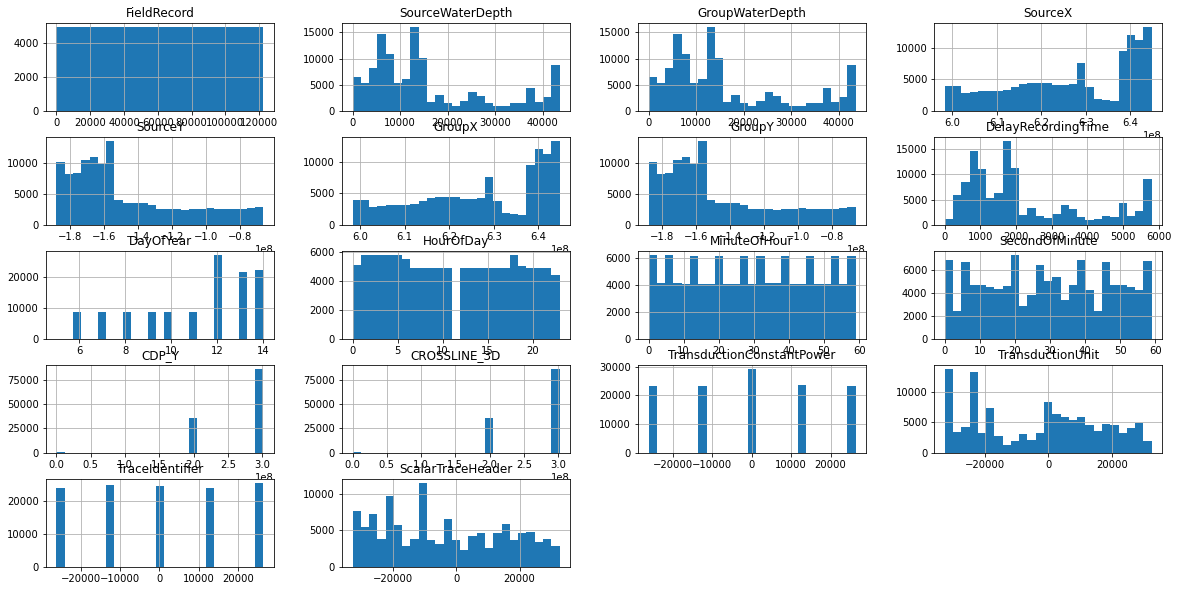

In [ ]:
# plot up those quantities
plot = scrape.hist(bins=25, figsize=(20, 10))


In [ ]:
# Inline and crossline must have something to do with the criss-crossing pattern usually taken by a vessel when conducting seismic surveys
trace_headers[['INLINE_3D','CROSSLINE_3D']]

,INLINE_3D,CROSSLINE_3D
0,8270,251658240
1,8270,251658240
2,8270,251658240
3,8270,251658240
4,8270,251658240
...,...,...
122526,8270,0
122527,8270,0
122528,8270,0
122529,8270,0


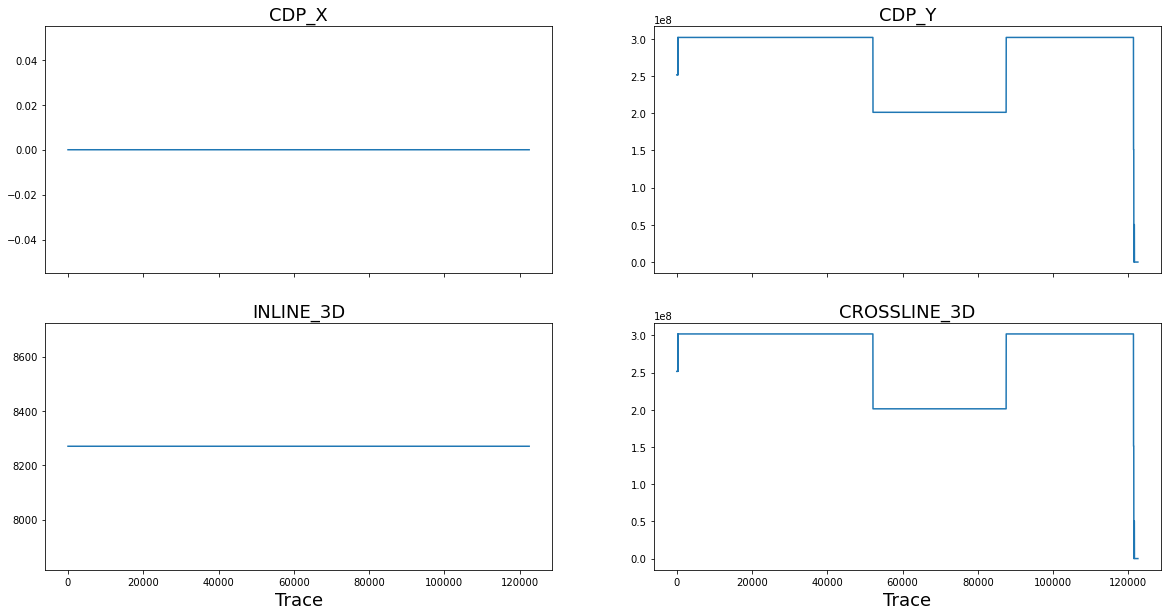

In [ ]:
# Plot some of the info:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20,10),sharex=True)
for ax, prop in zip(axs.ravel(), ["CDP_X","CDP_Y","INLINE_3D","CROSSLINE_3D"]):
    ax.plot(trace_headers[prop])
    ax.set_title(prop, fontdict={"fontsize":18})

for ax in axs[1,:]:
    ax.set_xlabel("Trace",fontdict={"fontsize":18})

### Viewing trace data

Segysak loads trace data into a xarray object. A single trace is a seismic waveform. Sensor readings of each point of that trace waveform may be accessed by using the trace number and two-way traveltime (TWT) as indices.

In [ ]:

# ValueError: No byte locatons for s, select from ['standard_3d', 'standard_3d_gath', 'standard_2d', 'standard_2d_gath', 'petrel_3d', 'petrel_2d']

# load all the info
# The INLINE and CROSSLINE byte location are important for dataloading for 3D so that the package can import a sequential data format into a cube.
# Can load either 2D or 3D data by specifying the byte location
# Argument names are usually the the same/similar to the pertinent trace header names
# The cropping arguments allow you to load smaller subsets of the total dataset.

# seems that the default trace headers work
# The first step the data_loader does is to perform a header scrape to get the trace headers
# The data is then loaded afterwards into the data structure
# An xarray.Dataset object is returned: a collection of different data variables that can share common dimensions, and has labled coordiantes
# extra_byte_fields will let you access specified columns
data = segy_loader(path32)

  0%|          | 0.00/123k [00:00<?, ? traces/s]

Couldn't determine geometry, will load traces as flat 2D.


Converting SEGY:   0%|          | 0.00/123k [00:00<?, ? traces/s]

In [ ]:
# as an xarray cube
data

<xarray.Dataset>
Dimensions:  (cdp: 122531, twt: 5000)
Coordinates:
  * cdp      (cdp) int64 0 1 2 3 4 5 ... 122526 122527 122528 122529 122530
  * twt      (twt) float64 -2.0 -1.95 -1.9 -1.85 ... 247.8 247.9 247.9 248.0
Data variables:
    data     (cdp, twt) float32 237.0 74.0 -225.0 -338.0 ... 36.0 46.0 61.0 26.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         0.05
    text:                C 1Bathy2010 - V2. 0. 1. 27  January 05, 2020  23:47...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         20200105234732R-LF.seg
    srd:                 None
    datatype:            None
    percentiles:         [-6250.831176400185, -4765.766014010012, -248.126496...
    coord_scalar:        -1000.0

In [ ]:
# as a dataframe. Notice bathymetric seismic is 2D data (two-way travel time and tranducer signal "data"). 
# The CDP "Common Depth Point" identifies the trace number.
data.to_dataframe()

data
cdp    twt           
0      -2.00    237.0
       -1.95     74.0
       -1.90   -225.0
       -1.85   -338.0
       -1.80   -323.0
...               ...
122530  247.75   32.0
        247.80   36.0
        247.85   46.0
        247.90   61.0
        247.95   26.0

[612655000 rows x 1 columns]

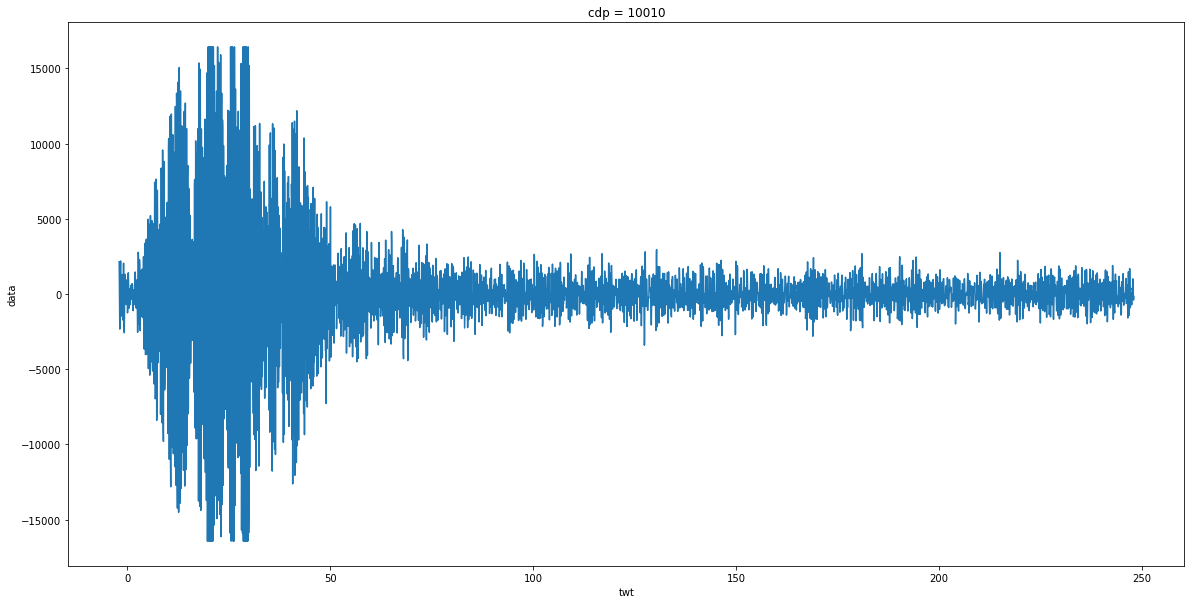

In [ ]:
# look at the data for one trace (chosen CDP is 10010)
_ = data.sel(cdp=10010).data.T.plot(yincrease=True,figsize=(20,10))

In [ ]:
# dataset anatomy: dimensions, coordinates, variables, attributes
print(data.cdp.shape)
print(data.data.shape)
print(data.sel(cdp=1, twt=-2.0))

(122531,)
(122531, 5000)
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    cdp      int64 1
    twt      float64 -2.0
Data variables:
    data     float32 -471.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         0.05
    text:                C 1Bathy2010 - V2. 0. 1. 27  January 05, 2020  23:47...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         20200105234732R-LF.seg
    srd:                 None
    datatype:            None
    percentiles:         [-6250.831176400185, -4765.766014010012, -248.126496...
    coord_scalar:        -1000.0


In [ ]:
# information about the xarray cube object:

print(data.dims) # get the dimenions
print(data.coords)
print(data.variables)
print(data.cdp) # returns a data array
print(data.data.shape)
print(data.attrs.keys())

Frozen({'cdp': 122531, 'twt': 5000})
Coordinates:
  * cdp      (cdp) int64 0 1 2 3 4 5 ... 122526 122527 122528 122529 122530
  * twt      (twt) float64 -2.0 -1.95 -1.9 -1.85 ... 247.8 247.9 247.9 248.0
Frozen({'cdp': <xarray.IndexVariable 'cdp' (cdp: 122531)>
array([     0,      1,      2, ..., 122528, 122529, 122530], dtype=int64), 'twt': <xarray.IndexVariable 'twt' (twt: 5000)>
array([ -2.  ,  -1.95,  -1.9 , ..., 247.85, 247.9 , 247.95]), 'data': <xarray.Variable (cdp: 122531, twt: 5000)>
array([[ 237.,   74., -225., ...,  119.,  -22., -460.],
       [-471., -524., -529., ..., -163.,   89.,  367.],
       [ 160.,  -26., -163., ...,  399., -312., -676.],
       ...,
       [  12.,  -11.,  -36., ...,   40.,  -14.,    0.],
       [  34.,   30.,    5., ...,   73.,   88.,   30.],
       [ -36.,    2.,   63., ...,   46.,   61.,   26.]], dtype=float32)})
<xarray.DataArray 'cdp' (cdp: 122531)>
array([     0,      1,      2, ..., 122528, 122529, 122530], dtype=int64)
Coordinates:
  * cdp    

In [ ]:
# output jupyter cell to a file
%%capture cap --no-stderr
print(trace_headers.info())
with open('./output.txt', 'w') as f:
    f.write(cap.stdout)

UsageError: Line magic function `%%capture` not found.


# Reformat columns from CSV

Note: I initially used the CSV files to reformat bathymetric data to MGD77T but found it is actually easier to just use the SEG-Y files instead. Leaving the functionality here below in case it needs to be used in the future.

The columns to reformat are the measurement time, latitude, longitude, date, and water depth. Make sure the datatypes reflect what should be present in the MGD77T format. The rounding I am using here are 4 decimal places for decimal time, and 6 decimal places for decimal degrees LAT/LON. With the rounding here the LAT/LON values give a precision down to about 11 centimeters. 

In [ ]:
# import file

csv = pathlib.Path(record['filepath'])
print("Does file exist: ", csv, csv.exists())
data = pd.read_csv(csv)

Does file exist:  input_files\bathymetric\20200105234732-1.CSV True


In [ ]:
# show first few samples of data
data.head()

,Unnamed: 0,time,latitude,longitude,Unnamed: 4,water_depth,Unnamed: 6,Unnamed: 7
0,$SDODC,23:47:34,S18.23.1061,E177.10.3017,A,1985.3,M,A
1,$SDODC,23:47:44,S18.23.1365,E177.10.3038,A,1986.4,M,A
2,$SDODC,23:47:54,S18.23.1700,E177.10.3062,A,1988.1,M,A
3,$SDODC,23:48:04,S18.23.2039,E177.10.3089,A,1989.1,M,A
4,$SDODC,23:48:14,S18.23.2374,E177.10.3116,A,1989.1,M,A


### Rename and drop columns

In [ ]:
#### Rename existing columns ####

columns = {
    "time" : "TIME",
    "latitude": "LAT",
    "longitude":"LON",
    "water_depth": "CORR_DEPTH"
}

data.rename(columns=columns,inplace=True)
data.head()

#### Drop unnecessary columns ####
data = data[columns.values()]
data.head()

,TIME,LAT,LON,CORR_DEPTH
0,23:47:34,S18.23.1061,E177.10.3017,1985.3
1,23:47:44,S18.23.1365,E177.10.3038,1986.4
2,23:47:54,S18.23.1700,E177.10.3062,1988.1
3,23:48:04,S18.23.2039,E177.10.3089,1989.1
4,23:48:14,S18.23.2374,E177.10.3116,1989.1


### Reformat time

In [ ]:
## Convert time to hours and decimal minutes:
# The time concatenates the hour and minute and takes the form hhmm
# Minutes are decimal minutes.

tmp_df = pd.DataFrame(columns=('h','m','s'))

# split time on colons
tmp_df[['h','m','s']] = data['TIME'].str.split(':',expand=True).astype('int32')

# convert datatypes and to decimal minutes
tmp_df['h_corr'] = tmp_df['h']
tmp_df['m_corr'] =  tmp_df['m'] + tmp_df['s']/60
tmp_df['TIME'] = (tmp_df['h_corr'].astype('str') + tmp_df['m_corr'].astype('str')).astype('float')

# rounding 4 decimal places as specified in MGD77T documentation
tmp_df['TIME'] = tmp_df['TIME'].round(4)

tmp_df.head()

,h,m,s,h_corr,m_corr,TIME
0,23,47,34,23,47.566667,2347.5667
1,23,47,44,23,47.733333,2347.7333
2,23,47,54,23,47.900000,2347.9000
3,23,48,4,23,48.066667,2348.0667
4,23,48,14,23,48.233333,2348.2333


### Reformat latitude

In [ ]:
# Convert latitude to decimal degress
tmp_df[['char','deg','min']] = data['LAT'].str.extract('([N|S|E|W])(\d+)\.(\d+\.\d+)', expand=True)
tmp_df['LAT'] = (tmp_df['deg'].astype(int) + tmp_df['min'].astype(float) / 60) * tmp_df['char'].map({'N':1, 'S':-1, 'E': 1, 'W':-1})
tmp_df['LAT'] = tmp_df['LAT'].round(6)
tmp_df.head()

,h,m,s,h_corr,m_corr,TIME,char,deg,min,LAT,LON
0,23,47,34,23,47.566667,2347.5667,S,18,23.1061,-18.385102,177.171695
1,23,47,44,23,47.733333,2347.7333,S,18,23.1365,-18.385608,177.171730
2,23,47,54,23,47.900000,2347.9000,S,18,23.1700,-18.386167,177.171770
3,23,48,4,23,48.066667,2348.0667,S,18,23.2039,-18.386732,177.171815
4,23,48,14,23,48.233333,2348.2333,S,18,23.2374,-18.387290,177.171860


### Reformat longitude

In [ ]:
# Convert longitude to decimal degress:
tmp_df[['char','deg','min']] = data['LON'].str.extract('([N|S|E|W])(\d+)\.(\d+\.\d+)', expand=True)
tmp_df['LON'] = (tmp_df['deg'].astype(int) + tmp_df['min'].astype(float) / 60) * tmp_df['char'].map({'N':1, 'S':-1, 'E': 1, 'W':-1})
tmp_df['LON'] = tmp_df['LON'].round(6)
tmp_df.head()

,h,m,s,h_corr,m_corr,TIME,char,deg,min,LAT,LON
0,23,47,34,23,47.566667,2347.5667,E,177,10.3017,-18.385102,177.171695
1,23,47,44,23,47.733333,2347.7333,E,177,10.3038,-18.385608,177.171730
2,23,47,54,23,47.900000,2347.9000,E,177,10.3062,-18.386167,177.171770
3,23,48,4,23,48.066667,2348.0667,E,177,10.3089,-18.386732,177.171815
4,23,48,14,23,48.233333,2348.2333,E,177,10.3116,-18.387290,177.171860


### Reformat date

In [ ]:
# Converting dates. There is no date column but the first date is given in the file header.
# Here I increment days when the clock switches from higher hour to lower hour (from 23 to 0)
# there is no way of distinguishing if the recording ended at 15 hrs today and was restarted at 16 hrs tomorrow
# in that case this code would recognize it as the same day.

tmp_df['DATE'] = datetime.date(record['first_date']['year'],record['first_date']['month'],record['first_date']['day'])
tmp_df.head()

for current in range(1, len(tmp_df[1:])):
    previous = current-1
    if tmp_df['h_corr'].iloc[current]  < tmp_df['h_corr'].iloc[previous]:
        new_date = tmp_df.loc[previous,'DATE'] + datetime.timedelta(days=1)
    else:
        new_date = tmp_df.loc[previous, 'DATE']
    
    tmp_df.loc[current, 'DATE'] = new_date

print(tmp_df['DATE'].unique())

# convert the date into the format specified in MGD77T
tmp_df['DATE'] = pd.to_datetime(tmp_df['DATE']).dt.strftime('%Y%m%d')

[datetime.date(2020, 1, 5) datetime.date(2020, 1, 6)
 datetime.date(2020, 1, 7) datetime.date(2020, 1, 8)
 datetime.date(2020, 1, 9) datetime.date(2020, 1, 10)
 datetime.date(2020, 1, 11) datetime.date(2020, 1, 12)
 datetime.date(2020, 1, 13) datetime.date(2020, 1, 14)]


### Reassign corrected columns

In [ ]:
insert_column(data, 0,'DATE', tmp_df['DATE'].copy())
data['TIME'] = tmp_df['TIME'].copy()
data['LAT'] = tmp_df['LAT'].copy()
data['LON'] = tmp_df['LON'].copy()
data.head()

,DATE,TIME,LAT,LON,CORR_DEPTH
0,20200105,2347.5667,-18.678056,178.004722,1985.3
1,20200105,2347.7333,-18.762500,178.010556,1986.4
2,20200105,2347.9000,-18.855556,178.017222,1988.1
3,20200105,2348.0667,-18.949722,178.024722,1989.1
4,20200105,2348.2333,-19.042778,178.032222,1989.1
